In [2]:
import numpy as np
from scipy.io import loadmat
import json
import os
import cv2
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import mixed_precision

In [3]:
mpii_folder = "mpii"
dataset_folder = os.path.join(mpii_folder, "mpii_human_pose_v1")
image_folder = os.path.join(dataset_folder, "images")

In [15]:
# optional for gpus with lower vram
mixed_precision.set_global_policy('mixed_float16')

In [4]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preparing the data
The images are .jpg files inside the images folder, while the joints/annotations for the images are located in a MATLAB file (.mat). We need to use the loadmat function to load the MATLAB file into the notebook. 



In [17]:
mat = loadmat(os.path.join(dataset_folder,'mpii_human_pose_v1_u12_1.mat'))
mat = mat['RELEASE']

In [18]:
data = []

for i, (anno, train) in enumerate(
    zip(mat['annolist'][0,0][0], 
        mat['img_train'][0,0][0])
):
    img_name = anno['image']['name'][0,0][0]
    train = int(train)
    
    for annorect in anno['annorect']:
        if annorect.size < 1 or 'scale' not in str(annorect.dtype):
            continue
            
        for i, annorect in enumerate(annorect):
            if annorect['scale'][0].size < 1:
                continue
                
            scale = float(annorect['scale'][0, 0])
            x, y = annorect['objpos'][0, 0]
            x = int(x[0,0])
            y = int(y[0,0])
            
            if 'annopoints' in str(anno['annorect'].dtype):
                annopoints = annorect['annopoints']
                if annopoints['point'][0][0].size == 16:
                    points = annopoints[0,0]
                    joint_coords = {}
                    visible_joints = {}
                    
                    for coord in points[0][0]:
                        joint_coords[int(coord['id'][0,0])] = [float(coord['x'][0,0]), float(coord['y'][0,0])]
                        visible_joints[int(coord['id'][0,0])] = coord['is_visible'].item() if (coord['is_visible'].size > 0) else 0
                    
                    data.append({
                        'filename': img_name,
                        'joint_coords': joint_coords,
                        'visible_joints': visible_joints,
                        'for_training': train,
                        'approx_loc': {
                            'scale': scale,
                            'x': x,
                            'y': y,
                        }
                    })
            else:
                data.append({
                        'filename': img_name,
                        'for_training': train,
                        'approx_loc': {
                            'scale': scale,
                            'x': x,
                            'y': y,
                        }
                    })

In [19]:
output_json = os.path.join(mpii_folder,'data.json')
file = open(output_json, 'w')
json.dump(data, file, indent=2)

## Checkout the data
Let's show a random image and overlay the joints

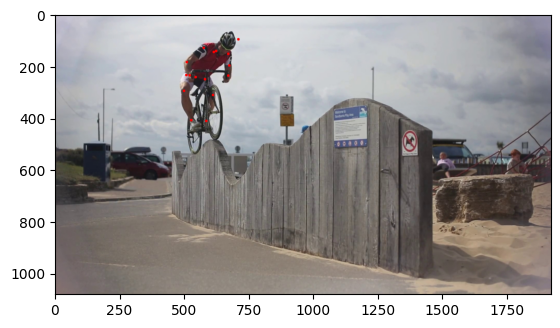

In [5]:
file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

def plot_joints(image_path, coordinates):
    image = cv2.imread(image_path)
    for joint in coordinates:
        cv2.circle(image, (int(joint[0]), int(joint[1])), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

example = data[420]
img_filename = example.get('filename')
joints = example.get('joint_coords')

joint_coords = []
for joint, coords in joints.items():
    joint_coords.append((coords[0], coords[1]))

plot_joints(os.path.join(image_folder,img_filename), joint_coords)

## Preprocessing the data
We will have to resize and crop the images to the same size, we will also save this into a HDF5 file as it handles large amounts of data very well

In [5]:
file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

In [6]:
def preprocess_image(img_path, objpos, scale, img_size=(128,128)):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    
    crop_size = int(scale * 200) # Scale factor of 200px from Dataset
    x1, y1 = int(objpos[0] - crop_size // 2), int(objpos[1] - crop_size // 2)
    x2, y2 = x1 + crop_size, y1 + crop_size
    
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    cropped_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, img_size)
    
    scale_factor = img_size[0] / crop_size
    transform_params = (x1, y1, scale_factor)
    
    return resized_img, transform_params

def adjust_keypoints(keypoints, transform_params):
    x1, y1, scale_factor = transform_params
    adjusted_keypoints = np.zeros((16,2), dtype=np.float32)
    
    for key, (x, y) in keypoints.items():
        x_new = (x - x1) * scale_factor
        y_new = (y - y1) * scale_factor
        adjusted_keypoints[int(key)] = [x_new, y_new]
    
    return adjusted_keypoints

In [7]:
def create_dataset(name, for_training):
    num_samples = sum(1 for ann in data if ann['for_training'] == for_training)
    
    with h5py.File(os.path.join(mpii_folder,name + '.h5'), 'w') as f:
        img_dataset = f.create_dataset("images", (num_samples, 128, 128, 3), dtype='uint8') # IMG SIZE (128,128,3)
        keypoints_dataset = f.create_dataset("keypoints", (num_samples, 16, 2), dtype='float32') # SIZE (16, 2)
        
        index = 0
        for ann in data:
            img_path = os.path.join(image_folder, ann['filename'])
            objpos = (ann['approx_loc']['x'], ann['approx_loc']['y'])
            scale = ann['approx_loc']['scale']
            
            preprocessed_img, transform_params = preprocess_image(img_path, objpos, scale)
            img_dataset[index] = preprocessed_img / 255.0
            
            if ann['for_training'] == for_training:
                adjusted_keypoints = adjust_keypoints(ann['joint_coords'], transform_params)
                keypoints_dataset[index] = adjusted_keypoints / 128.0
            
            index += 1
            if index >= num_samples: break
    
    print(name + ".h5 successfully created")

create_dataset('train_dataset', for_training=1)

train_dataset.h5 successfully created


## Load and Parse Data

In [8]:
file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

In [9]:
with h5py.File(os.path.join(mpii_folder, 'train_dataset.h5'), 'r') as f:
    images = np.array(f['images'])
    keypoints = np.array(f['keypoints'])

In [17]:
num_samples = sum(1 for ann in data if ann['for_training'] == 1)
dataset = tf.data.Dataset.from_tensor_slices((images, keypoints)).shuffle(num_samples, seed=42).batch(16).prefetch(tf.data.AUTOTUNE)

In [131]:
def build_simple(input_shape, num_keypoints=16):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (3,3), padding='same', activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    shortcut = x
    x = layers.Conv2D(128, (3,3), padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    
    shortcut = layers.Conv2D(256, (1,1), padding='same')(x)
    x = layers.Conv2D(256, (3,3), padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3,3), padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    
    x = layers.Conv2D(256, (3,3), strides=2, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(num_keypoints, (1,1), activation="sigmoid")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(num_keypoints * 2)(x)
    outputs = layers.Reshape((num_keypoints, 2))(x)
    
    model = keras.Model(inputs, outputs, name="Better_Simple_Keypoint_Detection")
    return model

input_shape = (128,128,3)
model = build_simple(input_shape)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

Model: "Better_Simple_Keypoint_Detection"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_63 (Conv2D)             (None, 128, 128, 64  1792        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_56 (BatchN  (None, 128, 128, 64  256        ['conv2d_63[0][0]']              
 ormalization)                  )                                  

In [132]:
model.fit(dataset, epochs=1)

1245/1245 [==============================] - 266s 212ms/step - loss: inf - mae: 2.0992


In [133]:
model.save('model_v3.keras')

## Let's work on the test data

In [129]:
model = tf.keras.models.load_model('model_v2.keras')

file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

In [56]:
def preprocess_test_image(test_image):
    image, transform_params = preprocess_image(
        os.path.join(image_folder, test_image['filename']), 
        (test_image['approx_loc']['x'], test_image['approx_loc']['y']), 
        test_image['approx_loc']['scale']
    )
    
    image = image / 255.0
    return image, transform_params

def visualize_predictions(img_path, keypoints):
    img = cv2.imread(img_path)
    for (x, y) in keypoints:
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def restore_keypoints(predictions, transform_params):
    x1, y1, scale_factor = transform_params
    keypoints = []

    for i in range(predictions.shape[1]):
        x_pred, y_pred = predictions[0, i]
        x_orig = (x_pred / scale_factor) + x1
        y_orig = (y_pred / scale_factor) + y1
        keypoints.append((x_orig, y_orig))

    return keypoints

1/1 [==============================] - 0s 149ms/step


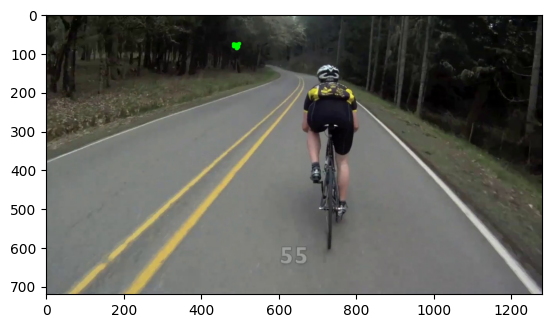

In [135]:
testdata = []
for ann in data:
    if ann['for_training'] == 0:
        testdata.append(ann)

test_image = testdata[10139]
test_image_location = os.path.join(image_folder, test_image['filename'])

input_image, transform_params = preprocess_test_image(test_image)
predictions = model.predict(np.expand_dims(input_image, axis=0))

restored_keypoints = restore_keypoints(predictions, transform_params)
visualize_predictions(test_image_location, restored_keypoints)